<a href="https://colab.research.google.com/github/SMSinclair/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Stephen_Sinclair_LS_DS4_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
y = 'health outcome' - predicted variable - dependent variable
x = 'drug usage' - explanatory variable - independent variable

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10) # Random seed for reproducability

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=172.07500125969045, mobile=False), User(purchased=False, time_on_site=242.1604565076447, mobile=True), User(purchased=True, time_on_site=172.4562884302345, mobile=True), User(purchased=False, time_on_site=134.30741730988564, mobile=True), User(purchased=False, time_on_site=176.6659151415657, mobile=False), User(purchased=False, time_on_site=98.57704667574383, mobile=True), User(purchased=False, time_on_site=141.90635886960914, mobile=True), User(purchased=False, time_on_site=46.30954508769639, mobile=True), User(purchased=True, time_on_site=568.9570603645093, mobile=False), User(purchased=False, time_on_site=64.57737234489078, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,172.075001,False
1,False,242.160457,True
2,True,172.456288,True
3,False,134.307417,True
4,False,176.665915,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.167894147962072,5.230051694531813,5.859655940198439,6.0175026563650755,6.029351938631506,6.076534025386882,7.530625255773601,7.817115390608255,7.825127435732432,7.9926238138229575,...,582.0038712877167,585.1679472229359,588.9784218509578,589.6238169166027,594.952201290341,595.4861528820476,595.6859588006147,597.9686255982785,599.821842253337,599.9043999383127
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,1,1,1,1,0,...,1,1,0,1,1,1,0,0,1,0
True,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,1


In [0]:
#!pip freeze

In [0]:
#!pip install pandas==0.23.4

In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

# Square bracket is inclusive

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.573, 124.115]","(124.115, 243.062]","(243.062, 362.01]","(362.01, 480.957]","(480.957, 599.904]"
purchased,,,,,
False,249,212,119,42,22
True,100,139,84,15,18


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.573, 124.115]","(124.115, 243.062]","(243.062, 362.01]","(362.01, 480.957]","(480.957, 599.904]"
purchased,,,,,
False,0.713467,0.603989,0.586207,0.736842,0.55
True,0.286533,0.396011,0.413793,0.263158,0.45


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.728,0.616
True,0.272,0.384


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
            rownames=['device'], 
            colnames=['purchased', 'time on site'],
            normalize='index')
ct

purchased               False                                       \
time on site (4.573, 124.115] (124.115, 243.062] (243.062, 362.01]   
device                                                               
False                0.172000           0.120000          0.180000   
True                 0.274667           0.242667          0.098667   

purchased                                                    True   \
time on site (362.01, 480.957] (480.957, 599.904] (4.573, 124.115]   
device                                                               
False                    0.168              0.088         0.036000   
True                     0.000              0.000         0.121333   

purchased                                                            \
time on site (124.115, 243.062] (243.062, 362.01] (362.01, 480.957]   
device                                                                
False                  0.056000             0.048              0.06   
True                   0.166667             0.096              0.00   

purchased                        
time on site (480.957, 599.904]  
device                           
False                     0.072  
True                      0.000

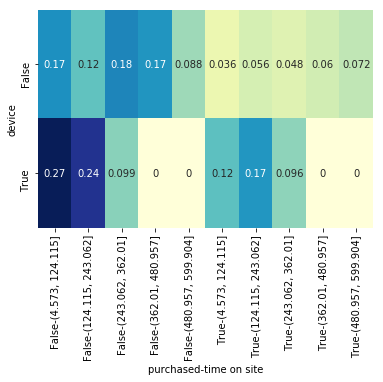

In [0]:
import seaborn as sns
sns.heatmap(ct, cmap="YlGnBu", annot=True, cbar=False)

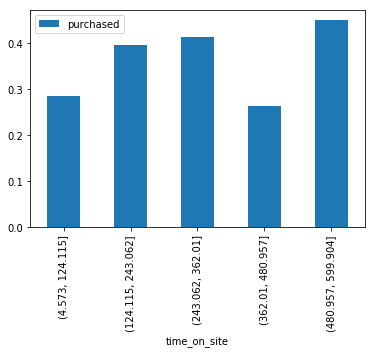

In [0]:
pd.pivot_table(user_data, values='purchased', 
               index=time_bins).plot.bar()

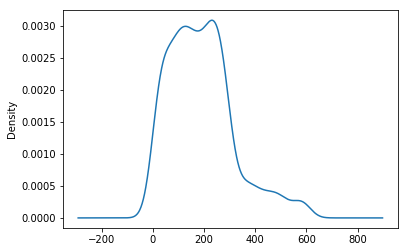

In [0]:
user_data['time_on_site'].plot.density()

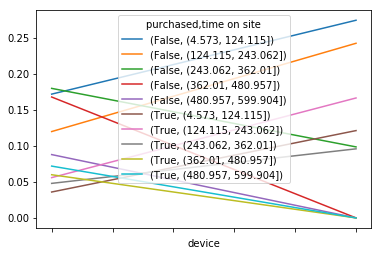

In [0]:
ct.plot()

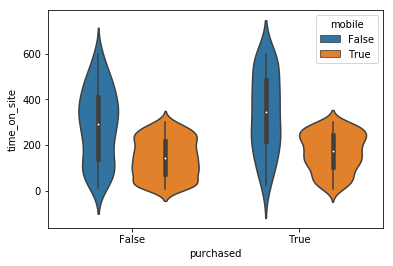

In [0]:
sns.violinplot(user_data['purchased'],user_data['time_on_site'],hue=user_data['mobile'])

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [170]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

# Loading the CSV from the raw URL on GitHub
# Setting the first column as index, deleting name
# Checking that the data loaded properly

df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
df = df.set_index('Unnamed: 0')
del df.index.name
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [171]:
df.tail()

,age,weight,exercise_time
1195,47,195,1
1196,29,210,22
1197,29,147,15
1198,25,149,185
1199,67,154,84


In [172]:
# Having a look at the basic summary statistics
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [173]:
# Confirming that all of the data from the csv file is in the dataframe
df.shape

(1200, 3)

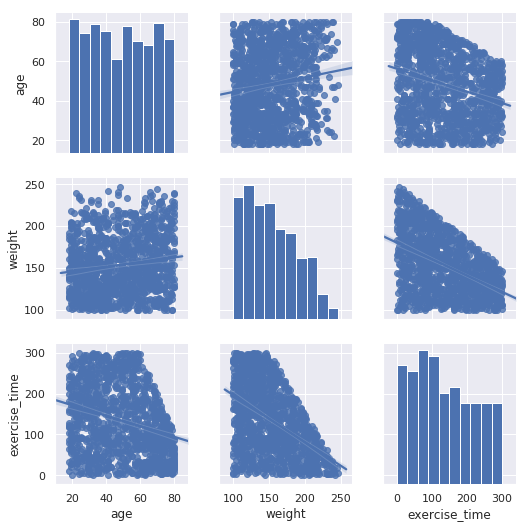

In [174]:
import seaborn as sns
sns.pairplot(df, kind='reg')

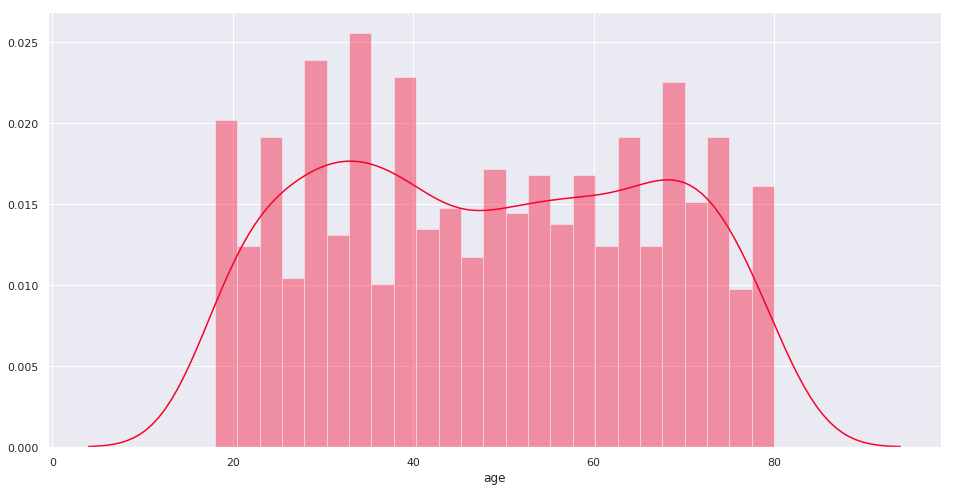

In [175]:
import matplotlib.pyplot as plt
sns.set()

fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(df['age'], color=sns.xkcd_rgb["cherry red"], bins=25);

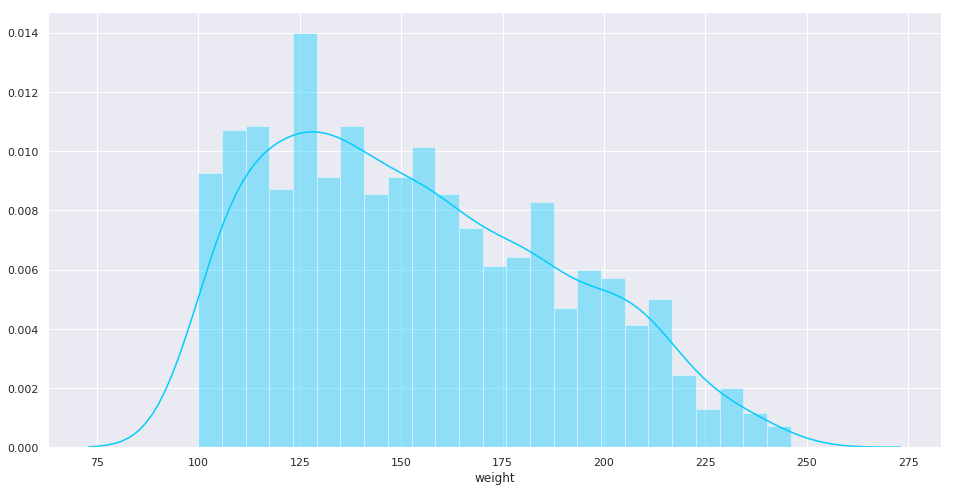

In [176]:
# Weight appears to be skewed to the right. The mean is greater than the median
# and there's a long tail on the right.
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(df['weight'], color=sns.xkcd_rgb["bright sky blue"], bins=25);

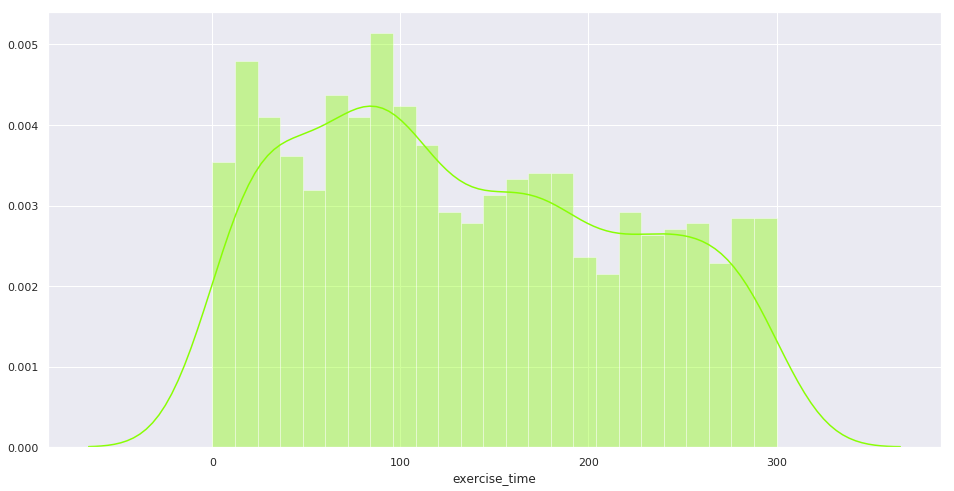

In [177]:
# Exercise time appears to be right skewed as well.
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(df['exercise_time'], color=sns.xkcd_rgb["lime green"], bins=25);

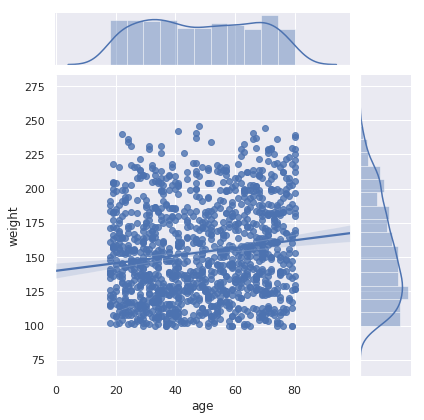

In [178]:
sns.jointplot(df['age'], df['weight'], kind='reg');

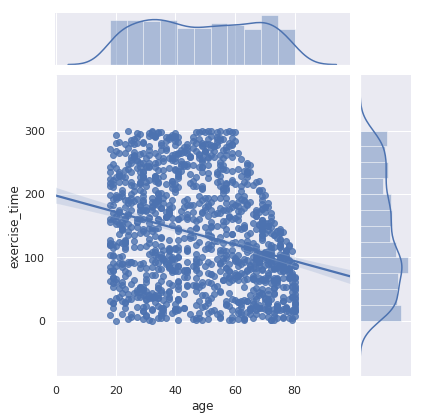

In [179]:
sns.jointplot(df['age'], df['exercise_time'], kind='reg');

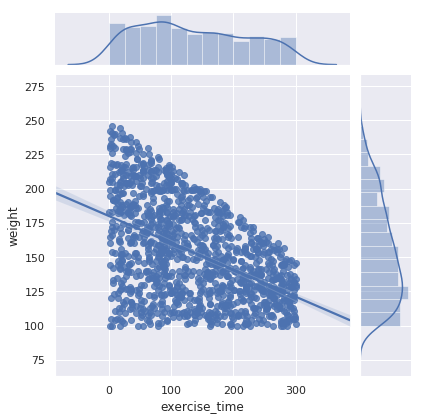

In [180]:
sns.jointplot(df['exercise_time'], df['weight'], kind='reg');

In [0]:
def sixty_or_greater(row):
  if row.age > 59:
    return True
  else:
    return False

In [0]:
df['sixty_plus'] = df.apply(sixty_or_greater, axis=1)

In [183]:
df.tail()

,age,weight,exercise_time,sixty_plus
1195,47,195,1,False
1196,29,210,22,False
1197,29,147,15,False
1198,25,149,185,False
1199,67,154,84,True


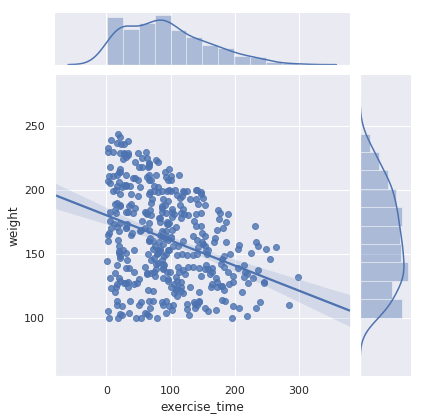

In [184]:
sns.jointplot(df[df.sixty_plus==True].exercise_time, df[df.sixty_plus==True].weight, kind='reg');

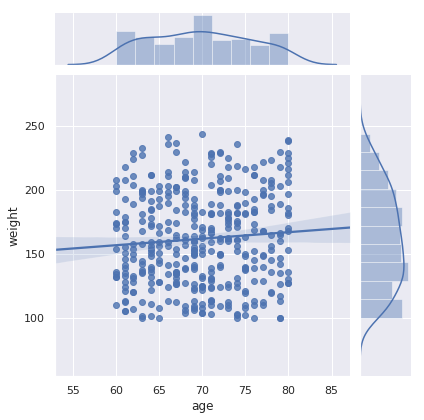

In [185]:
sns.jointplot(df[df.sixty_plus==True].age, df[df.sixty_plus==True].weight, kind='reg');

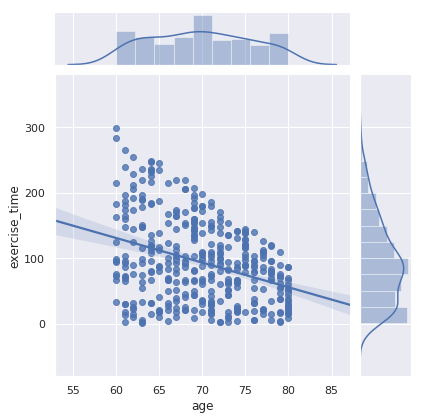

In [186]:
sns.jointplot(df[df.sixty_plus==True].age, df[df.sixty_plus==True].exercise_time, kind='reg');

In [0]:
bins = [0,30,45,60,85]
df['binned_age'] = pd.cut(df['age'], bins)

In [207]:
df.head(10)

,age,weight,exercise_time,sixty_plus,binned_age
0,44,118,192,False,"(30, 45]"
1,41,161,35,False,"(30, 45]"
2,46,128,220,False,"(45, 60]"
3,39,216,57,False,"(30, 45]"
4,28,116,182,False,"(0, 30]"
5,58,103,165,False,"(45, 60]"
6,55,161,107,False,"(45, 60]"
7,21,188,37,False,"(0, 30]"
8,55,216,79,False,"(45, 60]"
9,50,127,267,False,"(45, 60]"


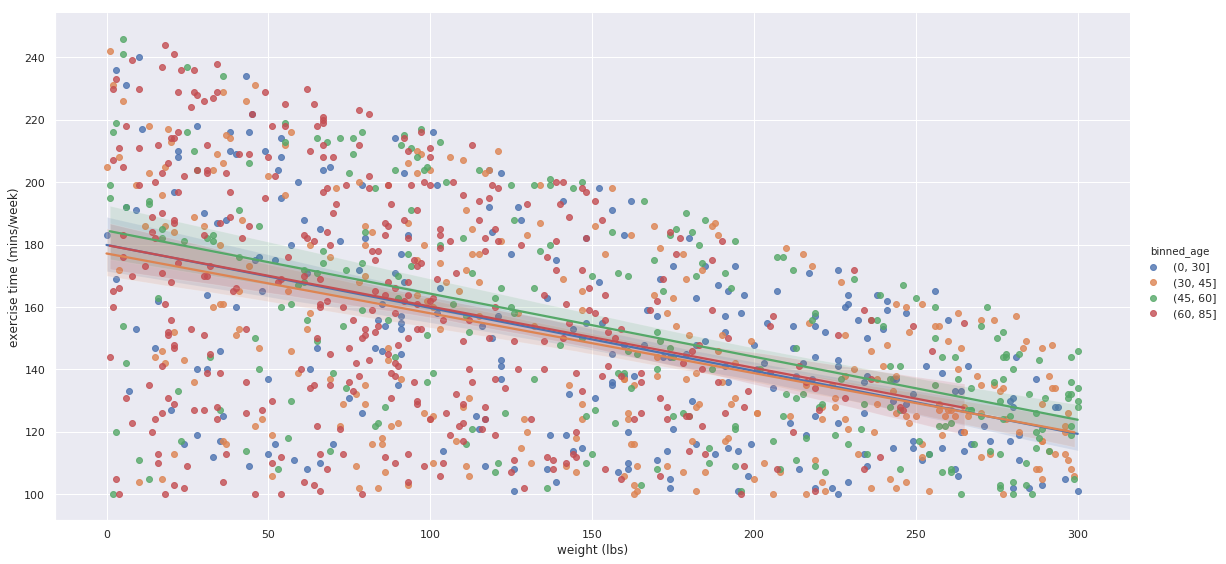

In [208]:
g = sns.lmplot(x="exercise_time", y="weight", hue="binned_age",
               truncate=True, data=df, height=8, aspect=2)

# Use more informative axis labels than are provided by default
g.set_axis_labels("weight (lbs)", "exercise time (mins/week)")

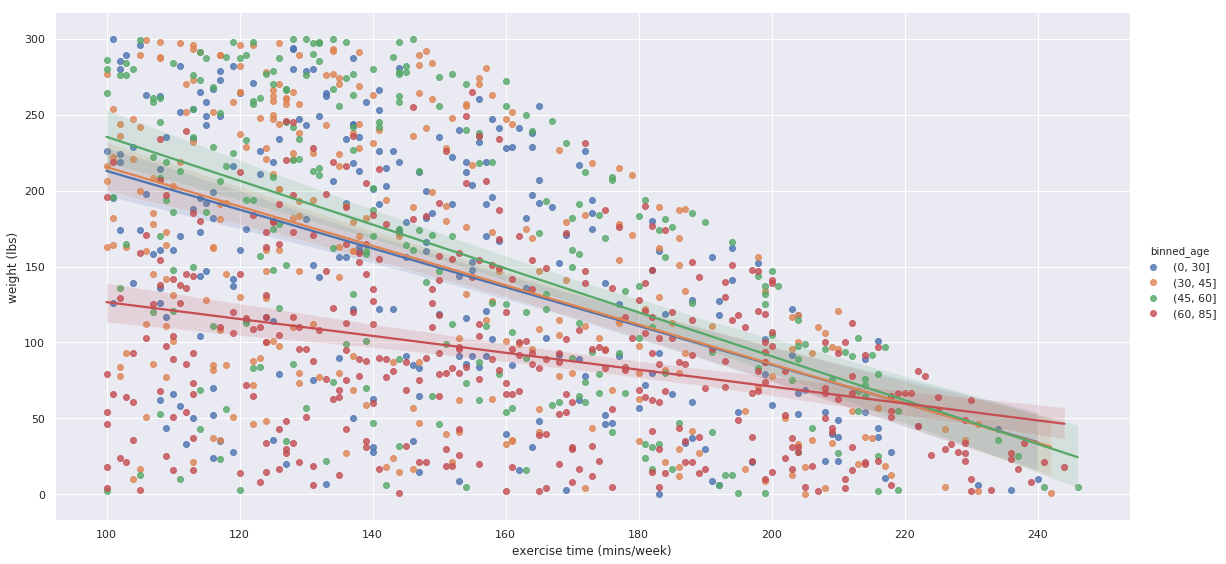

In [209]:
g = sns.lmplot(x="weight", y="exercise_time", hue="binned_age",
               truncate=True, data=df, height=8, aspect=2)

# Use more informative axis labels than are provided by default
g.set_axis_labels("exercise time (mins/week)", "weight (lbs)")

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

      The variables are integers, they're representing continuous values
      
2.  What are the relationships between the variables?

Weight seems to decrease as exercise time increases. As age increases, weight goes up slightly and exercise time declines.

3.  Which relationships are "real", and which spurious?

It seems like exercise time and and weight are correlated, but that in people over 60, it takes much more exercise to decrease weight.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)
-Use a groupby object 